In [ ]:
import zipfile
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2

def recortar_imagen_centro(imagen, lado_cuadrado):
    ancho, alto = imagen.size
    izquierda = (ancho - lado_cuadrado) // 2
    superior = (alto - lado_cuadrado) // 2
    derecha = (ancho + lado_cuadrado) // 2
    inferior = (alto + lado_cuadrado) // 2
    return imagen.crop((izquierda, superior, derecha, inferior))

def pixel_to_temperature(pixel_value, min_temp=16, max_temp=25, min_pixel=0, max_pixel=255):
    return (pixel_value - min_pixel) / (max_pixel - min_pixel) * (max_temp - min_temp) + min_temp

# Parámetros
lado_cuadrado = 400
zip_path = 'Imagenes_termicas.zip'
internal_folder = 'Imagenes_celda_peltier/'
results = []

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    imagenes_en_zip = [f for f in zip_ref.namelist() if f.startswith(internal_folder) and f.endswith('.png')]

    for ruta_interna in imagenes_en_zip:
        with zip_ref.open(ruta_interna) as file:
            imagen = Image.open(file)
            imagen_recortada = recortar_imagen_centro(imagen, lado_cuadrado)
            imagen_np = np.array(imagen_recortada)
            imagen_np = cv2.cvtColor(imagen_np, cv2.COLOR_RGB2BGR)
            reducidaC = cv2.resize(imagen_np, (int(imagen_np.shape[1] * 0.2), int(imagen_np.shape[0] * 0.2)))
            RC_gray = cv2.cvtColor(reducidaC, cv2.COLOR_BGR2GRAY)

            # Mostrar imagen recortada
            plt.figure(figsize=(4, 4))
            plt.imshow(cv2.cvtColor(reducidaC, cv2.COLOR_BGR2RGB))
            plt.title(f'Recorte: {os.path.basename(ruta_interna)}')
            plt.axis('off')
            plt.show()

            # Histograma
            plt.hist(RC_gray.ravel(), bins=256, range=(0, 255), edgecolor='black')
            plt.xlabel('Valor de gris')
            plt.ylabel('Frecuencia')
            plt.title(f'Histograma: {os.path.basename(ruta_interna)}')
            plt.show()

            # Primer contorno (C1)
            _, threshC = cv2.threshold(RC_gray, 190, 255, cv2.THRESH_BINARY_INV)
            contoursC, _ = cv2.findContours(threshC, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

            h, w = RC_gray.shape
            centro_x = w // 2
            margen_central = w * 0.2

            contornos_filtrados = [c for c in contoursC if 530 <= cv2.contourArea(c) <= 1900]
            contours_filteredC = []
            for c in contornos_filtrados:
                x, y, cw, ch = cv2.boundingRect(c)
                centro_contorno = x + cw // 2
                if y < h * 0.3:
                    if centro_contorno < centro_x - margen_central or centro_contorno > centro_x + margen_central:
                        contours_filteredC.append(c)
                else:
                    contours_filteredC.append(c)

            if len(contours_filteredC) == 0:
                print("No se detectaron contornos válidos. Usando contornos pequeños.")
                contours_filteredC = [c for c in contoursC if 5 <= cv2.contourArea(c) <= 440]

            maskC = np.zeros(RC_gray.shape, dtype=np.uint8)
            cv2.drawContours(maskC, contours_filteredC, -1, (255), -1)
            RC_cropped = cv2.bitwise_and(reducidaC, reducidaC, mask=maskC)

            # Mostrar imagen binaria y contornos C1
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.imshow(threshC, cmap='gray')
            plt.title('Binaria C1')
            plt.axis('off')

            plt.subplot(1, 3, 2)
            contorno_img = reducidaC.copy()
            cv2.drawContours(contorno_img, contours_filteredC, -1, (0, 255, 0), 1)
            plt.imshow(cv2.cvtColor(contorno_img, cv2.COLOR_BGR2RGB))
            plt.title('Contornos C1')
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(cv2.cvtColor(RC_cropped, cv2.COLOR_BGR2RGB))
            plt.title('Recorte C1')
            plt.axis('off')
            plt.show()

            r, g, b = cv2.split(RC_cropped)
            avg_red0 = np.mean(r[r > 0]) if np.any(r > 0) else 0
            avg_green0 = np.mean(g[g > 0]) if np.any(g > 0) else 0
            avg_blue0 = np.mean(b[b > 0]) if np.any(b > 0) else 0
            sumaC = sum([v for v in [avg_red0, avg_green0, avg_blue0] if v > 0])
            contador = sum([v > 0 for v in [avg_red0, avg_green0, avg_blue0]])
            promedioC1 = sumaC / contador if contador > 0 else 0

            # Segundo contorno (F1)
            _, thresh = cv2.threshold(RC_gray, 140, 255, cv2.THRESH_BINARY_INV)
            contours, _ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

            contours_filtered = []
            for c in contours:
                if 60 <= cv2.contourArea(c) <= 500:
                    x, y, cw, ch = cv2.boundingRect(c)
                    centro_contorno = x + cw // 2
                    if centro_contorno > margen_central and centro_contorno < w - margen_central:
                        contours_filtered.append(c)

            maskF = np.zeros(RC_gray.shape, dtype=np.uint8)
            cv2.drawContours(maskF, contours_filtered, -1, (255), -1)
            R0_cropped = cv2.bitwise_and(reducidaC, reducidaC, mask=maskF)

            # Mostrar imagen binaria y contornos F1
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.imshow(thresh, cmap='gray')
            plt.title('Binaria F1')
            plt.axis('off')

            plt.subplot(1, 3, 2)
            contorno_imgF = reducidaC.copy()
            cv2.drawContours(contorno_imgF, contours_filtered, -1, (255, 0, 0), 1)
            plt.imshow(cv2.cvtColor(contorno_imgF, cv2.COLOR_BGR2RGB))
            plt.title('Contornos F1')
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(cv2.cvtColor(R0_cropped, cv2.COLOR_BGR2RGB))
            plt.title('Recorte F1')
            plt.axis('off')
            plt.show()

            rF, gF, bF = cv2.split(R0_cropped)
            avg_red0F = np.mean(rF[rF > 0]) if np.any(rF > 0) else 0
            avg_green0F = np.mean(gF[gF > 0]) if np.any(gF > 0) else 0
            avg_blue0F = np.mean(bF[bF > 0]) if np.any(bF > 0) else 0
            sumaF = sum([v for v in [avg_red0F, avg_green0F, avg_blue0F] if v > 0])
            contadorF = sum([v > 0 for v in [avg_red0F, avg_green0F, avg_blue0F]])
            promedioCF = sumaF / contadorF if contadorF > 0 else 0

            C1 = pixel_to_temperature(promedioC1)
            F1 = pixel_to_temperature(promedioCF)

            print(f"{ruta_interna}: C1 = {C1:.2f} °C, F1 = {F1:.2f} °C")
            results.append({'archivo': os.path.basename(ruta_interna), 'C1': round(C1, 2), 'F1': round(F1, 2)})


# Guardar resultados (sobrescribir CSV)
df = pd.DataFrame(results)
df.to_csv('resultados_temperatura.csv', index=False)
print("Resultados guardados en 'resultados_temperatura.csv'")

                     archivo     C1     F1
0    2025-09-18_18-50-36.png  23.31  22.27
1    2025-09-18_18-50-47.png  23.29  22.22
2    2025-09-18_18-50-59.png  23.21  22.17
3    2025-09-18_18-51-10.png  23.37  22.22
4    2025-09-18_18-51-27.png  23.36  22.24
..                       ...    ...    ...
352  2025-09-18_20-31-49.png  21.78  21.04
353  2025-09-18_20-32-05.png  20.59  23.70
354  2025-09-18_20-32-21.png  22.32  22.15
355  2025-09-18_20-32-37.png  21.47  22.35
356  2025-09-18_20-32-49.png  21.57  22.29

[357 rows x 3 columns]


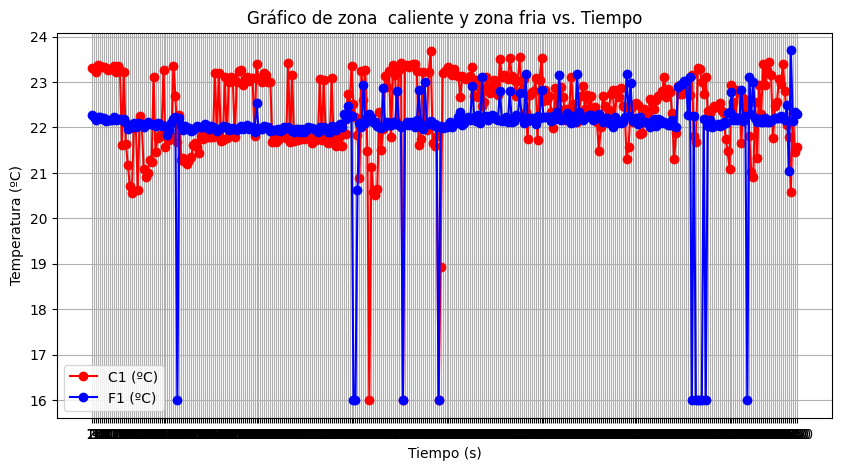

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# Leer el archivo CSV
datos = pd.read_csv('resultados_temperatura.csv')

# Verifica que los datos se han cargado correctamente
print(datos)

# Crear una columna de tiempo
n = len(datos)  # Número de filas en el DataFrame
tiempo = [i * 10 for i in range(n)]  # Generar tiempo cada 10 segundos

# Crear el DataFrame nuevo con tiempo
datos['tiempo'] = tiempo

# Graficar las variables C1 y F1
plt.figure(figsize=(10, 5))
plt.plot(datos['tiempo'], datos['C1'], marker='o', linestyle='-', color='r', label='C1 (ºC)')
plt.plot(datos['tiempo'], datos['F1'], marker='o', linestyle='-', color='b', label='F1 (ºC)')

# Añadir títulos y etiquetas
plt.title('Gráfico de zona  caliente y zona fria vs. Tiempo')
plt.xlabel('Tiempo (s)')
plt.ylabel('Temperatura (ºC)')
plt.xticks(range(0, int(tiempo[-1]) + 10, 10))  # Ajustar ticks del eje x
plt.grid()
plt.legend()
plt.show()